This module is based on the data present in kaggle:

https://www.kaggle.com/datasets/rajnathpatel/ner-data/data

A few links which were consmed while curating this notebook
- https://towardsdatascience.com/named-entity-recognition-with-bert-in-pytorch-a454405e0b6a
- https://colab.research.google.com/drive/1lsTTJJAgymED55UXRzxu_T3utxzkqP6M?usp=sharing
- https://medium.com/@ameydhote007/fine-tuning-language-models-for-ner-a-hands-on-step-by-step-guide-408cfee1e93b
- https://github.com/Kanishkparganiha/Named-Entity-Recognition-using-BERT-with-PyTorch/blob/master/Source%20Code.ipynb
- https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Custom_Named_Entity_Recognition_with_BERT.ipynb


Bert as NER extractor

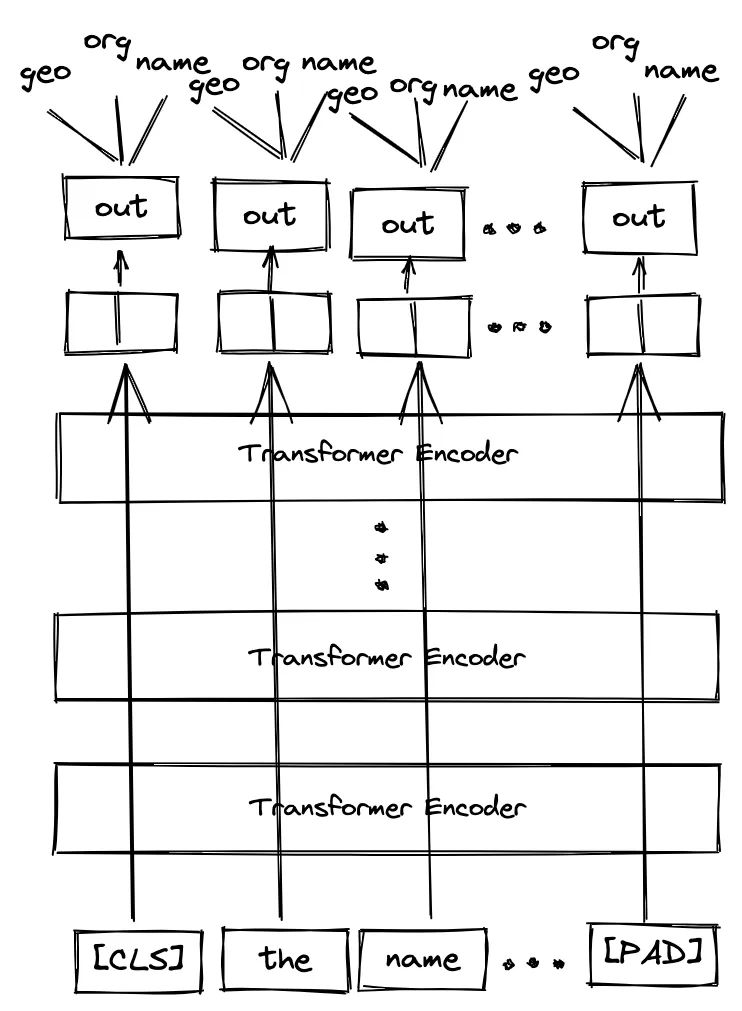

In [1]:
%autosave 300
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os

os.chdir(
    "/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run2/code/Users/soutrik.chowdhury/abi_genai_bert_ner"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run2/code/Users/soutrik.chowdhury/abi_genai_bert_ner


In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [4]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [5]:
from transformers import BertTokenizer, BertTokenizerFast, BertForTokenClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

In [6]:
LEARNING_RATE = 5e-3
EPOCHS = 5
BATCH_SIZE = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
MAX_LEN=256

In [7]:
ner_df = pd.read_csv("data/ner.csv")

In [8]:
ner_df.head()

,text,labels
0,Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .,O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O
1,"Iranian officials say they expect to get access to sealed sensitive parts of the plant Wednesday , after an IAEA surveillance system begins functioning .",B-gpe O O O O O O O O O O O O O O B-tim O O O B-org O O O O O
2,"Helicopter gunships Saturday pounded militant hideouts in the Orakzai tribal region , where many Taliban militants are believed to have fled to avoid an earlier military offensive in nearby South Waziristan .",O O B-tim O O O O O B-geo O O O O O B-org O O O O O O O O O O O O O O B-geo I-geo O
3,They left after a tense hour-long standoff with riot police .,O O O O O O O O O O O
4,"U.N. relief coordinator Jan Egeland said Sunday , U.S. , Indonesian and Australian military helicopters are ferrying out food and supplies to remote areas of western Aceh province that ground crews can not reach .",B-geo O O B-per I-per O B-tim O B-geo O B-gpe O B-gpe O O O O O O O O O O O O O B-geo O O O O O O O O


In [9]:
ner_df = ner_df.sample(frac=0.2).reset_index(drop=True)
print(ner_df.shape)

(9592, 2)


In total, there are 9 entity categories, which are:

* geo for geographical entity
* org for organization entity
* per for person entity
* gpe for geopolitical entity
* tim for time indicator entity
* art for artifact entity
* eve for event entity
* nat for natural phenomenon entity
* O is assigned if a word doesn’t belong to any entity.

Next we will standardize the labels

In [10]:
# all_labels_list = [i.split() for i in ner_df["labels"].tolist()]
# print(len(all_labels_list))

In [11]:
# # assesmble all unique labels in a set
# unique_labels = set()
# for lb in all_labels_list:
#     [unique_labels.add(i) for i in lb if i not in unique_labels]

In [12]:
# print(unique_labels)

In [13]:
# # creating label mapping for keys
# label_key_map = {v:k for k,v in enumerate(unique_labels)}
# key_label_map = {k:v for k,v in enumerate(unique_labels)}

In [14]:
def basic_data_preprocessing(df):
    """
    This function will take the dataframe and return the text and labels list
    """
    all_text_list = df["text"].tolist()
    all_labels_list = [i.split() for i in ner_df["labels"].tolist()]
    return all_text_list, all_labels_list


def create_label_mapping(all_labels_list):
    """
    This function will take the labels list and return the label mapping
    """
    unique_labels = set()
    for lb in all_labels_list:
        [unique_labels.add(i) for i in lb if i not in unique_labels]
    # creating label mapping for keys
    label_key_map = {v: k for k, v in enumerate(unique_labels)}
    key_label_map = {k: v for k, v in enumerate(unique_labels)}

    return label_key_map, key_label_map

In [15]:
all_text_list, all_labels_list = basic_data_preprocessing(ner_df)
label_key_map, key_label_map = create_label_mapping(all_labels_list)

In [16]:
print(f"The length of all text list is: {len(all_text_list)}")
print(f"The length of all labels list is: {len(all_labels_list)}")
print(f"The length of label key map is: {len(label_key_map)}")
print(f"The length of key label map is: {len(key_label_map)}")
print(f"The label key map is: {label_key_map}")

The length of all text list is: 9592
The length of all labels list is: 9592
The length of label key map is: 17
The length of key label map is: 17
The label key map is: {'I-tim': 0, 'B-gpe': 1, 'B-geo': 2, 'I-art': 3, 'B-org': 4, 'B-art': 5, 'B-tim': 6, 'O': 7, 'I-geo': 8, 'B-per': 9, 'B-nat': 10, 'I-org': 11, 'B-eve': 12, 'I-per': 13, 'I-eve': 14, 'I-nat': 15, 'I-gpe': 16}


IOB tagging. I means Intermediate and B means Beginning and O means Outside

Experimentation

In [17]:
tokenizer_1 = BertTokenizerFast.from_pretrained("bert-base-cased")
tokenizer_2 = BertTokenizer.from_pretrained("bert-base-cased")

In [49]:
sample_text = all_text_list[211]
sample_labels = all_labels_list[211]
print(sample_text)
print(sample_labels)

In another town , Balad Ruz , police say a rocket attack on a policeman 's house killed the man 's brother and four children .
['O', 'O', 'O', 'O', 'B-per', 'I-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [50]:
op1 = tokenizer_1.encode_plus(
    sample_text,
    max_length=512,
    truncation=True,
    padding="max_length",
    return_tensors="pt",
    return_token_type_ids=True,
    return_attention_mask=True,
    return_offsets_mapping=True,
    return_special_tokens_mask=True,
    return_overflowing_tokens=True,
    
)
print(op1.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'special_tokens_mask', 'offset_mapping', 'overflow_to_sample_mapping'])


In [51]:
op2 = tokenizer_2.encode_plus(
    sample_text,
    max_length=512,
    truncation=True,
    padding="max_length",
    return_tensors="pt",
)
print(op2.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [52]:
# tokenizer_2.encode_plus

In [53]:
(op1["input_ids"] != 0).sum()

tensor(32)

In [54]:
(op2["input_ids"] != 0).sum()

tensor(32)

The Encoding style is diff - We will use Fast Tokenizer for added advantage of unknown tokens space and all , Please read about it in details

In [55]:
tokenizer_1.decode(op1["input_ids"][0])

"[CLS] In another town, Balad Ruz, police say a rocket attack on a policeman's house killed the man's brother and four children. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

We got our original sequence back after implementing decode method with the addition of special tokens from BERT such as [CLS] token at the beginning of the sequence, [SEP] token at the end of the sequence, and a bunch of [PAD] tokens to fulfill the required maximum length of 512.

#### Adjusting Label After Tokenization

The BERT tokenizer uses the so-called word-piece tokenizer under the hood, which is a sub-word tokenizer. This means that BERT tokenizer will likely to split one word into one or more meaningful sub-words.

In [56]:
sub_word_tokens = tokenizer_1.convert_ids_to_tokens(op1["input_ids"][0])
print(sub_word_tokens)
print(len([id for id in sub_word_tokens if id != "[PAD]"]))
print(len(sample_text.split()))

['[CLS]', 'In', 'another', 'town', ',', 'Ba', '##lad', 'R', '##uz', ',', 'police', 'say', 'a', 'rocket', 'attack', 'on', 'a', 'policeman', "'", 's', 'house', 'killed', 'the', 'man', "'", 's', 'brother', 'and', 'four', 'children', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 

subcomandante was split into 3 subwords and addition of cls + sep and rest of the tokens would be padded with 0

There are two problems that we need to address after tokenization process:

* The addition of special tokens from BERT such as [CLS], [SEP], and [PAD]
* The fact that some tokens are splitted into sub-words.
* As sub-word tokenization, word-piece tokenization splits uncommon words into their sub-words
* The consequence of this word piece tokenization and the addition of special tokens from BERT is that the sequence length after tokenization is no longer matching the length of the initial label.

To solve this problem, we need to adjust the label such that it has the same length as the sequence after tokenization

In [57]:
word_ids = (
    op1.word_ids()
)  # Return a list mapping the tokens to their actual word in the initial sentence
print(word_ids)
print(sub_word_tokens)

[None, 0, 1, 2, 3, 4, 4, 5, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

These word_ids will be very useful to adjust the length of the label by applying either of these two methods:

* We only provide a label to the first sub-word of each splitted token. The continuation of the sub-word then will simply have ‘-100’ as a label. All tokens that don’t have word_ids will also be labeled with ‘-100’.
* We provide the same label among all of the sub-words that belong to the same token. All tokens that don’t have word_ids will be labeled with ‘-100’.

In [58]:
def align_label_example(tokenized_input, labels, label_key_map, label_all_tokens=True):
    """
    Align the labels to the tokenized inputs. This can be used for NER or token classification tasks.
    :param tokenized_input: Tokenized input from the tokenizer
    :param labels: Labels to align
    :param label_key_map: Mapping between the labels and the label ids
    :param label_all_tokens: If True, all tokens are given a label. If False, only the first token of a word is given a label.

    """
    # print(f"label_key_map: {label_key_map}")
    word_ids = (
        tokenized_input.word_ids()
    )  # Return a list mapping the tokens to their actual word in the initial sentence
    labels_ids = []  # list of labels for each token
    previous_word_idx = None  # keep track of the previous word index

    for word_idx in word_ids:
        if word_idx is None:
            # print(f"Word index is None: {word_idx}")
            labels_ids.append(-100)

        elif word_idx != previous_word_idx:
            # print("current word index is not equal to previous word index")
            try:
                labels_ids.append(label_key_map[labels[word_idx]])
            except:
                labels_ids.append(-100)

        else:
            try:
                labels_ids.append(
                    label_key_map[labels[word_idx]] if label_all_tokens else -100
                )
            except:
                labels_ids.append(-100)

        # set the previous word index
        previous_word_idx = word_idx

    return labels_ids

In [59]:
new_labels = align_label_example(
    op1, sample_labels, label_key_map, label_all_tokens=True
)

In [60]:
print(new_labels)
print(sub_word_tokens)

[-100, 7, 7, 7, 7, 9, 9, 13, 13, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -

In [63]:
print(len(new_labels))
print(len(sub_word_tokens))

512
512


In [64]:
print([key_label_map[i] if i != -100 else "SPL" for i in new_labels])

['SPL', 'O', 'O', 'O', 'O', 'B-per', 'B-per', 'I-per', 'I-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SPL', 'SP

Custom Dataset for Modelling

In [65]:
class NerDataset(Dataset):
    def __init__(
        self,
        dataset,
        label_key_map,
        label_all_tokens,
        tokenizer,
    ):
        super(NerDataset, self).__init__()
        self.dataset = dataset
        self.all_text_list, self.all_labels_list = basic_data_preprocessing(
            dataset)
        self.tokenizer = tokenizer
        self.label_key_map = label_key_map
        self.label_all_tokens = label_all_tokens

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        text = self.all_text_list[index]
        labels = self.all_labels_list[index]

        tokenized_input = self.tokenizer.encode_plus(
            text,
            max_length=MAX_LEN,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )

        labels = align_label_example(
            tokenized_input, labels, self.label_key_map, self.label_all_tokens
        )

        return {
            "input": tokenized_input,
            "labels": torch.tensor(labels, dtype=torch.long),
        }

In [66]:
bert_tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
label_all_tokens = True

split the dataset into 2 

In [67]:
train_df, test_df = train_test_split(ner_df, test_size=0.2, random_state=42)
print(train_df.shape, test_df.shape)

(7673, 2) (1919, 2)


In [68]:
train_dataset = NerDataset(train_df, label_key_map,
                           label_all_tokens, bert_tokenizer)
test_dataset = NerDataset(test_df, label_key_map,
                          label_all_tokens, bert_tokenizer)

In [69]:
# next(iter(train_dataset))

In [70]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers = 4

)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers = 4
)

In [71]:
for data in train_dataloader:
    print(data["input"]["input_ids"].shape)
    print(data["labels"].shape)
    break

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([8, 1, 256])
torch.Size([8, 256])


In [72]:
var_a = data["input"]["input_ids"]
print(var_a.shape)
print(var_a.squeeze(1).shape)

torch.Size([8, 1, 256])
torch.Size([8, 256])


#### Model Training and Evaluation

In [73]:
class BertNerModel(nn.Module):
    def __init__(
        self,
    ) -> None:
        super().__init__()
        self.bert = BertForTokenClassification.from_pretrained(
            "bert-base-cased", num_labels=len(label_key_map)
        )

    def forward(self, input_ids, attention_mask, labels):
        outputs = self.bert(
            input_ids=input_ids, attention_mask=attention_mask, labels=labels
        )
        return outputs

In [74]:
model = BertNerModel()
model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertNerModel(
  (bert): BertForTokenClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(28996, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=

In [75]:
# Choosing to apply decay based on the layer type excluding bias and LayerNorm weights and include transformer layers

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]

In [76]:
# total no of training steps : len(dataset)/batch_size * epochs = len(train_dataloader) * epochs

num_training_steps = len(train_dataloader) * EPOCHS
print(num_training_steps)

4800


In [77]:
optimizer = AdamW(optimizer_parameters, lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

/anaconda/envs/torch_env/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Experiment

In [78]:
# input_ids = data["input"]["input_ids"].to(device)
# attention_mask = data["input"]["attention_mask"].to(device)
# labels = data["labels"].to(device)

# print(input_ids.shape, attention_mask.shape, labels.shape)
# input_ids = input_ids.squeeze(1)
# attention_mask = attention_mask.squeeze(1)
# print(input_ids.shape, attention_mask.shape)
# model.train()
# optimizer.zero_grad()

# outputs = model(input_ids, attention_mask, labels=labels)
# outputs
# loss = outputs.loss
# logits = outputs.logits
# loss
# print(logits.shape)
# print(logits[0].shape)
# print(labels[0].shape)
# flattened_targets = labels.view(-1)
# print(flattened_targets.shape)
# active_logits = logits.view(-1, len(label_key_map))
# print(active_logits.shape)
# flattened_predictions = torch.argmax(active_logits, axis=1)
# print(flattened_predictions.shape)
# flattened_predictions
# # only compute accuracy at active labels
# active_accuracy = labels.view(-1) != -100  # shape (batch_size, seq_len)
# print(active_accuracy.shape)
# labels = torch.masked_select(flattened_targets, active_accuracy)
# predictions = torch.masked_select(flattened_predictions, active_accuracy)
# print(labels.shape, predictions.shape)
# labels.sum(), predictions.sum()
# tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
# print(tmp_tr_accuracy)
# optimizer.zero_grad()
# loss.backward()
# optimizer.step()
# scheduler.step()
# nn.utils.clip_grad_norm_(model.parameters(), 1.0)

In [80]:
def training_loop(
    epoch, model, optimizer, scheduler, dataloader, device, label_key_map
):
    tr_loss, tr_accuracy = 0.0, 0.0
    tr_examples, tr_steps = 0, 0
    tr_preds = []
    tr_labels = []

    # put the model in training mode:
    model.train()

    for idx, batch in enumerate(dataloader):
        input_ids = batch["input"]["input_ids"].to(device)
        attention_mask = batch["input"]["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # squeeze the input_ids and attention_mask
        input_ids = input_ids.squeeze(1)
        attention_mask = attention_mask.squeeze(1)

        # zero the gradients
        optimizer.zero_grad()
        # forward pass
        output = model(input_ids, attention_mask, labels=labels)

        loss = output.loss
        logits = output.logits

        tr_loss += loss.item()
        tr_steps += 1  # steps are the number of batches in each epoch
        tr_examples += labels.size(0)

        if idx % 100 == 0:
            loss_step = tr_loss / tr_examples
            print(f"For Epoch: {epoch}, Step: {idx}, Train Loss: {loss_step}")

        # flatten targets and predictions
        flattened_targets = labels.view(
            -1
        )  # from (batch_size, seq_len) to (batch_size*seq_len,)
        active_logits = logits.view(
            -1, len(label_key_map)
        )  # from (batch_size, seq_len, num_labels) to (batch_size*seq_len, num_labels)
        flattened_predictions = torch.argmax(
            active_logits, axis=1
        )  # from (batch_size*seq_len, num_labels) to (batch_size*seq_len,)

        # only consider labels and predictions to store and calc metric on valid ones
        active_accuracy = labels.view(-1) != -100  # shape (batch_size, seq_len)
        labels = torch.masked_select(
            flattened_targets, active_accuracy
        )  # shape (valid_labels,)
        predictions = torch.masked_select(
            flattened_predictions, active_accuracy
        )  # shape (valid_labels,)

        # store predictions and labels
        tr_preds.extend(predictions.cpu().numpy())
        tr_labels.extend(labels.cpu().numpy())

        tmp_tr_accuracy = accuracy_score(
            labels.cpu().numpy(), predictions.cpu().numpy()
        )
        tr_accuracy += tmp_tr_accuracy

        # gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # backpropagation
        loss.backward()
        optimizer.step()
        scheduler.step()

    epoch_loss = tr_loss / tr_examples
    epoch_accuracy = tr_accuracy / tr_steps
    print(
        f"For Epoch: {epoch}, Train Loss: {epoch_loss}, Train Accuracy: {epoch_accuracy}"
    )

In [81]:
def validation_loop(epoch, model, dataloader, device, label_key_map, key_label_map):
    val_loss, val_accuracy = 0.0, 0.0
    val_examples, val_steps = 0, 0
    val_preds = []
    val_labels = []

    # put the model in evaluation mode:
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            input_ids = batch["input"]["input_ids"].to(device)
            attention_mask = batch["input"]["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # squeeze the input_ids and attention_mask
            input_ids = input_ids.squeeze(1)
            attention_mask = attention_mask.squeeze(1)

            outputs = model(input_ids, attention_mask, labels=labels)

            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            val_steps += 1
            val_examples += labels.size(0)

            if idx % 100 == 0:
                loss_step = val_loss / val_examples
                print(f"For Epoch: {epoch}, Step: {idx}, Val Loss: {loss_step}")

            # flatten targets and predictions
            flattened_targets = labels.view(
                -1
            )  # from (batch_size, seq_len) to (batch_size*seq_len,)
            active_logits = logits.view(
                -1, len(label_key_map)
            )  # from (batch_size, seq_len, num_labels) to (batch_size*seq_len, num_labels)
            flattened_predictions = torch.argmax(
                active_logits, axis=1
            )  # from (batch_size*seq_len, num_labels) to (batch_size*seq_len,)

            # only consider labels and predictions to store and calc metric on valid ones
            active_accuracy = labels.view(-1) != -100
            labels = torch.masked_select(
                flattened_targets, active_accuracy
            )  # shape (valid_labels,)
            predictions = torch.masked_select(
                flattened_predictions, active_accuracy
            )  # shape (valid_labels,)

            # store predictions and labels
            val_preds.extend(predictions.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

            tmp_val_accuracy = accuracy_score(
                labels.cpu().numpy(), predictions.cpu().numpy()
            )
            val_accuracy += tmp_val_accuracy

    # we change the predicted labels to actual labels
    val_labels = [key_label_map[id] for id in val_labels]
    val_preds = [key_label_map[id] for id in val_preds]

    epoch_loss = val_loss / val_examples
    epoch_accuracy = val_accuracy / val_steps

    print(f"For Epoch: {epoch}, Val Loss: {epoch_loss}, Val Accuracy: {epoch_accuracy}")

    return val_labels, val_preds

In [82]:
for epoch in range(EPOCHS):
    print(f"Epoch: {epoch}")
    training_loop(epoch, model, optimizer, scheduler, train_dataloader, device, label_key_map)
    val_labels, val_preds = validation_loop(epoch, model, test_dataloader, device, label_key_map, key_label_map)

Epoch: 0


/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


For Epoch: 0, Step: 0, Train Loss: 0.3650796413421631
For Epoch: 0, Step: 100, Train Loss: 0.12655172408512322
For Epoch: 0, Step: 200, Train Loss: 0.11551973297821348
For Epoch: 0, Step: 300, Train Loss: 0.1107218749202367
For Epoch: 0, Step: 400, Train Loss: 0.1073793476154828
For Epoch: 0, Step: 500, Train Loss: 0.1054160662530782
For Epoch: 0, Step: 600, Train Loss: 0.10407076800821626
For Epoch: 0, Step: 700, Train Loss: 0.10341310795508166
For Epoch: 0, Step: 800, Train Loss: 0.10317765052119891
For Epoch: 0, Step: 900, Train Loss: 0.10262725900416236
For Epoch: 0, Train Loss: 0.10217849596622139, Train Accuracy: 0.8390399642053977


/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


For Epoch: 0, Step: 0, Val Loss: 0.08485334366559982
For Epoch: 0, Step: 100, Val Loss: 0.0978908176616867
For Epoch: 0, Step: 200, Val Loss: 0.09942380092407933


/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


For Epoch: 0, Val Loss: 0.09955259969670553, Val Accuracy: 0.8391109078131389
Epoch: 1


/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


For Epoch: 1, Step: 0, Train Loss: 0.09751146286725998
For Epoch: 1, Step: 100, Train Loss: 0.09913831418103511
For Epoch: 1, Step: 200, Train Loss: 0.09922057620031917
For Epoch: 1, Step: 300, Train Loss: 0.09929021847654022
For Epoch: 1, Step: 400, Train Loss: 0.09855259519228317
For Epoch: 1, Step: 500, Train Loss: 0.09854797380204924
For Epoch: 1, Step: 600, Train Loss: 0.0982315164065599
For Epoch: 1, Step: 700, Train Loss: 0.09834488266056002
For Epoch: 1, Step: 800, Train Loss: 0.09812398253476129
For Epoch: 1, Step: 900, Train Loss: 0.09819780364136452


/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


For Epoch: 1, Train Loss: 0.09828182211696565, Train Accuracy: 0.8414365645335988


/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


For Epoch: 1, Step: 0, Val Loss: 0.08642838150262833
For Epoch: 1, Step: 100, Val Loss: 0.09923731686897797
For Epoch: 1, Step: 200, Val Loss: 0.10072489412714593
For Epoch: 1, Val Loss: 0.10086633936696651, Val Accuracy: 0.8391109078131389
Epoch: 2


/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


For Epoch: 2, Step: 0, Train Loss: 0.10494580119848251
For Epoch: 2, Step: 100, Train Loss: 0.09729409195704035
For Epoch: 2, Step: 200, Train Loss: 0.0984874096564689
For Epoch: 2, Step: 300, Train Loss: 0.09867540415240285
For Epoch: 2, Step: 400, Train Loss: 0.09699843855495761
For Epoch: 2, Step: 500, Train Loss: 0.09763351508124384
For Epoch: 2, Step: 600, Train Loss: 0.09793219369481289
For Epoch: 2, Step: 700, Train Loss: 0.09795152220061944
For Epoch: 2, Step: 800, Train Loss: 0.09747613723693269
For Epoch: 2, Step: 900, Train Loss: 0.09768537136743653
For Epoch: 2, Train Loss: 0.09808054017566972, Train Accuracy: 0.8413509843399416


/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


For Epoch: 2, Step: 0, Val Loss: 0.08628267049789429
For Epoch: 2, Step: 100, Val Loss: 0.09768246188022123
For Epoch: 2, Step: 200, Val Loss: 0.0991346121983445


/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


For Epoch: 2, Val Loss: 0.09925365604852375, Val Accuracy: 0.8391109078131389
Epoch: 3


/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


For Epoch: 3, Step: 0, Train Loss: 0.08128653466701508
For Epoch: 3, Step: 100, Train Loss: 0.09995887384261234
For Epoch: 3, Step: 200, Train Loss: 0.09897899451614613
For Epoch: 3, Step: 300, Train Loss: 0.09808715906897653
For Epoch: 3, Step: 400, Train Loss: 0.0972245193070307
For Epoch: 3, Step: 500, Train Loss: 0.09750618593034868
For Epoch: 3, Step: 600, Train Loss: 0.09767123148118001
For Epoch: 3, Step: 700, Train Loss: 0.0977314085501662
For Epoch: 3, Step: 800, Train Loss: 0.09767634624361843
For Epoch: 3, Step: 900, Train Loss: 0.09754146830686322
For Epoch: 3, Train Loss: 0.09780467989375441, Train Accuracy: 0.8414923155707866


/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


For Epoch: 3, Step: 0, Val Loss: 0.08549748361110687
For Epoch: 3, Step: 100, Val Loss: 0.09798276734234083
For Epoch: 3, Step: 200, Val Loss: 0.09952792593866439
For Epoch: 3, Val Loss: 0.09965519440118194, Val Accuracy: 0.8391109078131389
Epoch: 4


/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


For Epoch: 4, Step: 0, Train Loss: 0.06969296932220459
For Epoch: 4, Step: 100, Train Loss: 0.0965339148251137
For Epoch: 4, Step: 200, Train Loss: 0.09741492196917534
For Epoch: 4, Step: 300, Train Loss: 0.0984692890011393
For Epoch: 4, Step: 400, Train Loss: 0.09847627327477843
For Epoch: 4, Step: 500, Train Loss: 0.0984878114344712
For Epoch: 4, Step: 600, Train Loss: 0.09811300477524366
For Epoch: 4, Step: 700, Train Loss: 0.09804227240861908
For Epoch: 4, Step: 800, Train Loss: 0.0979150558604432
For Epoch: 4, Step: 900, Train Loss: 0.09786371625835835
For Epoch: 4, Train Loss: 0.09757681881746008, Train Accuracy: 0.8413027329770636


/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


For Epoch: 4, Step: 0, Val Loss: 0.08526920527219772
For Epoch: 4, Step: 100, Val Loss: 0.09791962488895596
For Epoch: 4, Step: 200, Val Loss: 0.0994258510940407


/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


For Epoch: 4, Val Loss: 0.09956354898298203, Val Accuracy: 0.8391109078131389
